In [1]:
import numpy as np
from matplotlib import rc, pyplot as plt
from matplotlib.animation import FuncAnimation as animate 
from sklearn.linear_model import LinearRegression
from typing import * 

rc('animation',html = 'html5')
%matplotlib inline

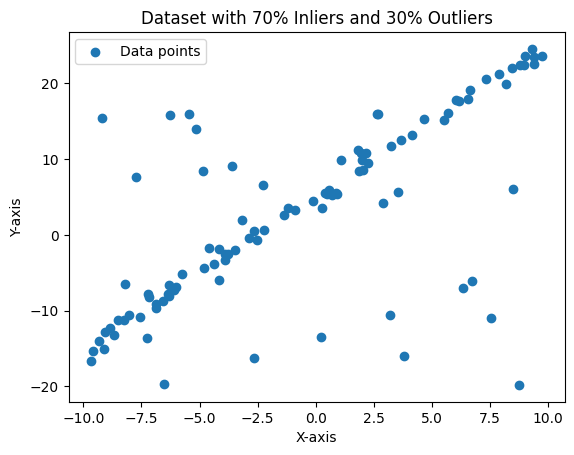

In [2]:

def generate_dataset(num_points, inlier_ratio=0.7, noise_std=1.0, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Generate inliers (linear relationship)
    inlier_count = int(num_points * inlier_ratio)
    inlier_slope = 2.0
    inlier_intercept = 5.0
    inliers_x = np.random.uniform(-10, 10, inlier_count)
    inliers_y = inlier_slope * inliers_x + inlier_intercept + np.random.normal(0, noise_std, inlier_count)

    # Generate outliers (random points)
    outlier_count = num_points - inlier_count
    outliers_x = np.random.uniform(-10, 10, outlier_count)
    outliers_y = np.random.uniform(-20, 20, outlier_count)

    # Combine inliers and outliers
    x = np.concatenate([inliers_x, outliers_x])
    y = np.concatenate([inliers_y, outliers_y])

    # Shuffle the dataset
    indices = np.arange(num_points)
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]

    return x, y

def plot_dataset(x, y, inlier_ratio):
    plt.scatter(x, y, label='Data points')
    plt.title(f'Dataset with {int(inlier_ratio * 100)}% Inliers and {int((1 - inlier_ratio) * 100)}% Outliers')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.show()

# Generate a dataset with 70% inliers and 30% outliers
num_points = 100
inlier_ratio = 0.7
noise_std = 1.0
seed = 42

x, y = generate_dataset(num_points, inlier_ratio, noise_std, seed)
plot_dataset(x, y, inlier_ratio)


In [3]:
_type_slope = NewType('slope',float)
_type_intercept = NewType('intercept',float)


# fig, ax = plt.subplots(figsize=(10,8))
class Ransac:
    def __init__(self,
                 data,
                 *,
                 min_sample=10,
                 max_iter=100,
                 residual_threshold=0.5) -> None:
        self._n = max_iter
        self._x = data[:,0]
        self._y = data[:,1]
        self.min_sample = min_sample
        self.thresh = residual_threshold
        self.__data = data 
        self.__max_inliers = 0

    def _compute_num_inliers(self,
                             m:_type_slope,
                             c:_type_intercept
                             )->Tuple[int,np.ndarray]:

        distances = np.abs((m* self._x - self._y+c)/ np.sqrt(1+m**2))
        idx = np.where(distances<=self.thresh)
        return self.__data[idx]

    def _fit_line(self,x,
                  y)->Tuple[_type_slope,_type_intercept]:
        model = LinearRegression()
        model.fit(x.reshape(-1,1),y)
        return model.coef_[0],model.intercept_
    
    def fit(self,*args):
        best_inliers = None 

        for _ in range(self._n):
                
            # ax.clear()
            # ax.scatter(self._x,self._y)
            random_sample_data = self.__data[np.random.choice(len(self.__data),self.min_sample,replace=False)]
            # ax.scatter(random_sample_data[:,0],random_sample_data[:,1],color='r')
            m,c = self._fit_line(random_sample_data[:,0],random_sample_data[:,1])
            f = lambda x: x*m+c
            # ax.plot([min(self._x),max(self._x)],[f(min(self._x)),f(max(self._x))],c='g')
            _inliers = self._compute_num_inliers(m,c)
            _num_inliers = len(_inliers)
            # ax.scatter(_inliers[:,0],_inliers[:,1],c='y')
            if _num_inliers>self.__max_inliers:
                self.__max_inliers = _num_inliers
                best_inliers = _inliers
            
            # print(_num_inliers,self.__max_inliers)
            # ax.text(0,18,f'max inliers {self.__max_inliers}')
            # ax.text(0,20,f'current inliers {_num_inliers}')
        return best_inliers


# Regression

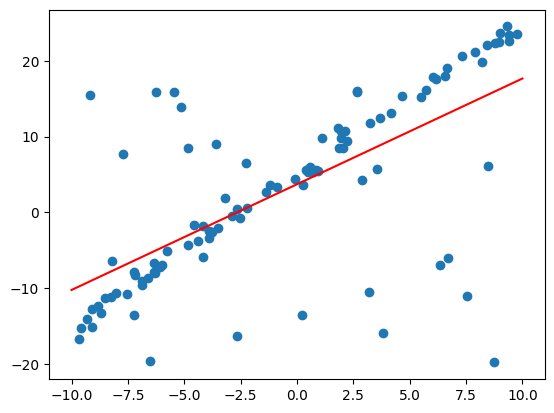

In [4]:
def regression(x,y):
     model = LinearRegression()
     model.fit(x.reshape(-1,1),y)
     m,c = model.coef_[0],model.intercept_
     f = lambda x:m*x + c
     plt.plot([-10,10],[f(-10),f(10)],c='r')
     plt.scatter(x,y)

regression(x,y) 

# RANSAC

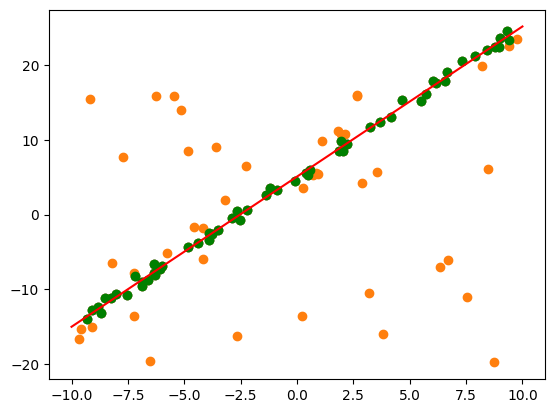

In [5]:
instance = Ransac(np.c_[x,y],residual_threshold=0.5)
                  # plots = animate(fig, func=instance.fit, frames = 100, interval= 2000, repeat= False)
# plots
inliers = instance.fit()
regression(inliers[:,0],inliers[:,1])
plt.scatter(x,y)
plt.scatter(inliers[:,0],inliers[:,1],c='g')
